# 🚗 Day 9 - Car Price Prediction 
### A Feature-Driven Machine Learning Approach for Predicting Used Car Resale Values with Regression Pipelines

This project builds an end-to-end machine learning pipeline that predicts used car prices by applying advanced feature engineering and regression modeling to uncover the key factors influencing resale value.

---

## 1. Introduction

Buying or selling a used car depends on multiple factors — such as brand, year of manufacture, mileage, fuel type, and ownership history.  
Accurately predicting the selling price of a used car helps both sellers and buyers make **data-driven decisions**.

This project focuses on building a **Machine Learning Model** that can predict the **selling price of a car** based on its attributes.  
Through systematic **data preprocessing**, **feature engineering**, and **model training**, we aim to develop a robust and explainable car price prediction system.


---

## 2. Project Objectives

The main objectives of this project are:

1. **Analyze and preprocess** real-world car resale data for modeling.  
2. **Engineer new features** that capture hidden relationships between car attributes and price.  
3. **Build a Machine Learning pipeline** for automated preprocessing and model training.  
4. **Train and evaluate** a regression model to predict car prices accurately.  
5. **Interpret model results** using feature importances to identify key factors influencing car prices.  
6. **Save and deploy** the trained model pipeline for future use.


---

## 3. Dataset Overview

The dataset contains detailed information about **4,340 used cars**, including their technical specifications and transaction prices.

| Column | Description |
|--------|-------------|
| `name` | Car model name |
| `year` | Manufacturing year |
| `selling_price` | Selling price (target variable) |
| `km_driven` | Kilometers driven |
| `fuel` | Type of fuel (Petrol/Diesel/CNG/LPG/Electric) |
| `seller_type` | Type of seller (Dealer/Individual/Trustmark Dealer) |
| `transmission` | Transmission type (Manual/Automatic) |
| `owner` | Number of previous owners |

### Key Insights:
- Dataset has **8 columns** and **4,340 records**.  
- No missing values were found.  
- Target variable: `selling_price` (continuous).  
- Contains both **numerical** and **categorical** features — ideal for regression.


---

## 4. Methodology and Approach

This project follows a structured end-to-end machine learning workflow:

1. **Data Loading & Exploration:**  
   Loaded the dataset, reviewed structure, and checked for missing or inconsistent values.

2. **Data Cleaning:**  
   Verified data quality and removed redundant columns.

3. **Feature Engineering:**  
   Created meaningful variables like `Car_Age` and `Price_per_km` to enhance model learning.

4. **Preprocessing Pipeline:**  
   Used `ColumnTransformer` to scale numeric features and one-hot encode categorical ones.

5. **Model Training:**  
   Trained a `RandomForestRegressor` within a unified pipeline for robust predictions.

6. **Model Evaluation:**  
   Assessed performance using **RMSE** and **R² Score** to measure accuracy.

7. **Model Interpretation & Saving:**  
   Analyzed feature importance to identify key predictors and saved the pipeline for reuse.


---

## 5. Tools and Libraries Used

| Category | Library | Purpose |
|-----------|----------|----------|
| **Data Handling** | `pandas`, `numpy` | Data manipulation and analysis |
| **Machine Learning** | `scikit-learn` | Model training, pipelines, preprocessing |
| **Model** | `RandomForestRegressor` | Predictive algorithm for regression |
| **Evaluation** | `mean_squared_error`, `r2_score` | Performance measurement |
| **Utilities** | `joblib`, `warnings`, `filedialpy` | Saving models, suppressing warnings, file selection |


---

## 6. Importing Libraries

In [14]:
import pandas as pd
import numpy as np
import filedialpy as fp
import joblib
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Configurations
warnings.filterwarnings("ignore")

print('All libraries loaded!')

All libraries loaded!


---

## 7. Data Loading & Initial Exploration

Before model development, it is essential to **load and examine the dataset** to understand its structure and contents.  
This step includes importing the data, inspecting column types, identifying missing values, and reviewing basic statistics.  
Early exploration helps ensure the data is accurate, consistent, and suitable for further preprocessing and modeling.


#### Load the Dataset

In [18]:
df = pd.read_csv(fp.openFile())
print('Data Loaded!')
df.head()

Data Loaded!


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


#### Dataset Shape

In [20]:
df.shape

(4340, 8)

#### Dataset Information

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


#### Statistical Summary

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,4340.0,2013.090783,4.215344,1992.0,2011.00,2014.0,2016.0,2020.0
selling_price,4340.0,504127.311751,578548.736139,20000.0,208749.75,350000.0,600000.0,8900000.0
km_driven,4340.0,66215.777419,46644.102194,1.0,35000.00,60000.0,90000.0,806599.0


#### Missing Values

In [26]:
print(df.isnull().sum().sum(), "missing values found.")

0 missing values found.


#### Unique values in each colunm

In [28]:
print("Unique values:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

Unique values:
name: 1491
year: 27
selling_price: 445
km_driven: 770
fuel: 5
seller_type: 3
transmission: 2
owner: 5


---

## 8. Feature Engineering — Creating Meaningful Predictors

In this step, we enhance the dataset by creating new features that provide better insights to the model.  
Feature engineering helps the model capture real-world relationships between a car’s attributes and its selling price.

#### Features Created:
1. **Car_Age:**  
   - Calculated as the difference between the current year (2025) and the car's manufacturing year.  
   - Represents how old the car is, which directly affects its resale value.

2. **Price_per_km:**  
   - Derived as `selling_price / (km_driven + 1)`  
   - Indicates the depreciation trend or value retention per kilometer driven.  
   - The `+1` prevents division-by-zero errors.

#### Columns Dropped:
- **name:** The car’s model name — too specific and not numerically meaningful.  
- **year:** Already used to calculate `Car_Age`, so no longer needed.

In [31]:
df2 = df.copy()
current_year = 2025
df['Car_Age'] = current_year - df['year']
df['Price_per_km'] = df['selling_price'] / (df['km_driven'] + 1)  # avoid div by 0

# Drop unneeded or leak-prone columns
df.drop(['name', 'year'], axis=1, inplace=True)

df.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,Car_Age,Price_per_km
0,60000,70000,Petrol,Individual,Manual,First Owner,18,0.857131
1,135000,50000,Petrol,Individual,Manual,First Owner,18,2.699946
2,600000,100000,Diesel,Individual,Manual,First Owner,13,5.999940
3,250000,46000,Petrol,Individual,Manual,First Owner,8,5.434664
4,450000,141000,Diesel,Individual,Manual,Second Owner,11,3.191467


These transformations make the dataset more informative while preventing data leakage and redundancy.



---

## 9. Define Feature Types — Numeric and Categorical Columns

Now that we’ve engineered new features, we’ll categorize our dataset’s columns into **numerical** and **categorical** types.  
This helps the preprocessing pipeline apply the correct transformations (scaling for numeric data, encoding for categorical data).


In [35]:
# Cell 4) Define columns
numeric_cols = ['km_driven', 'Car_Age', 'Price_per_km']
categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner']

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['km_driven', 'Car_Age', 'Price_per_km']
Categorical columns: ['fuel', 'seller_type', 'transmission', 'owner']


This separation ensures each data type is preprocessed optimally before model training.


---

## 10. Build the Preprocessing Pipeline

Before training, we must ensure the data is clean, standardized, and machine-readable.  
We’ll build a **scikit-learn ColumnTransformer pipeline** to handle preprocessing in an automated, consistent way.

#### Components:
1. **Numeric Transformer:**  
   - Imputes missing values using the median (robust to outliers).  
   - Standardizes data using `StandardScaler()` to center around zero.

2. **Categorical Transformer:**  
   - Fills missing categories with the most frequent value.  
   - Encodes categorical variables using `OneHotEncoder()`.

#### Why Use a Pipeline?
- Prevents data leakage  
- Ensures consistent preprocessing for both training and testing  
- Makes deployment simpler and reproducible

In [39]:
# Cell 5) Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

print("Preprocessing pipelines for numeric and categorical data created successfully.")

Preprocessing pipelines for numeric and categorical data created successfully.


---

## 11. Create the Full Machine Learning Pipeline

Next, we integrate the preprocessing steps with a regression model inside a single unified pipeline.  
This ensures that all data transformations are applied automatically before training or prediction.

#### Model Used:
- **Random Forest Regressor** — an ensemble-based algorithm that captures nonlinear patterns and feature interactions effectively.

#### Benefits of the Full Pipeline:
- Streamlined training and evaluation  
- No manual reprocessing of test data  
- Easy to save, reload, and deploy

In [42]:
# Cell 6) Full Pipeline
model = RandomForestRegressor(n_estimators=200, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

print("Full Machine Learning pipeline (Preprocessor + Model) assembled.")

Full Machine Learning pipeline (Preprocessor + Model) assembled.


---

## 12. Split the Dataset and Training the Model

To evaluate how well our model generalizes, we divide the dataset into:
- **Training Set (80%)** → used to train the model  
- **Testing Set (20%)** → used to evaluate performance on unseen data

We’ll also apply a **log transformation** on the target variable (`selling_price`) to stabilize variance and reduce the impact of extreme price values.


In [45]:
# Cell 7) Split data
X = df.drop(columns=['selling_price'])
y = df['selling_price']

# Log-transform target for stability
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (3472, 7)
Test shape: (868, 7)


#### 12.1 Train the Model

- We now fit the complete pipeline on the training data.  
- This step runs all preprocessing operations automatically (imputation, encoding, scaling),  
- followed by model training on the transformed features.

After fitting, the pipeline can directly be used for predictions or evaluation without any manual preprocessing.

In [47]:
# Cell 8) Fit pipeline
print("Training model...")
pipeline.fit(X_train, y_train)
print("Model trained successfully!")

Training model...
Model trained successfully!


---

## 13. Model Evaluation — Assessing Performance

After training the model, it’s crucial to evaluate how well it performs on unseen data.  
We’ll use the **Root Mean Squared Error (RMSE)** and **R² Score** as performance metrics:

- **RMSE (Root Mean Squared Error):**  
  Measures the average difference between predicted and actual prices (lower is better).

- **R² Score (Coefficient of Determination):**  
  Indicates how much variance in the target variable is explained by the model (closer to 1 is better).

The target variable (`selling_price`) was log-transformed during training to reduce skewness,  
so we now reverse the log transformation (`np.expm1`) before calculating these metrics.


In [50]:
# Cell 9) Evaluate model
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # reverse log transform
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

Test RMSE: 221840.41
R² Score: 0.839


---

## 14. Feature Importance — Understanding Key Predictors

To interpret the model, we examine **feature importances** from the trained Random Forest.  
Feature importance indicates how much each input contributes to predicting the car’s selling price.

#### Steps:
1. Retrieve the trained model and preprocessing steps from the pipeline.  
2. Get transformed feature names after OneHotEncoding.  
3. Compute feature importances using the model’s internal scoring.  
4. Sort and display the top 10 most influential features.

This helps us understand which car characteristics — such as age, kilometers driven, fuel type, or transmission —  
play the largest role in determining resale value.


In [53]:
# Cell 10) Feature importances
model = pipeline.named_steps['model']
pre = pipeline.named_steps['preprocessor']

# Get feature names after encoding
feature_names = (
    numeric_cols +
    list(pre.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))
)

importances = model.feature_importances_
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=False)
imp_df.head(10)

,Feature,Importance
2,Price_per_km,0.731264
0,km_driven,0.147336
4,fuel_Diesel,0.045199
12,transmission_Manual,0.028428
11,transmission_Automatic,0.025266
1,Car_Age,0.011661
7,fuel_Petrol,0.007836
9,seller_type_Individual,0.000884
8,seller_type_Dealer,0.000833
15,owner_Second Owner,0.000465


---

## 15. Data Visualization and Insights

#### 15.1 Distribution of Selling Price

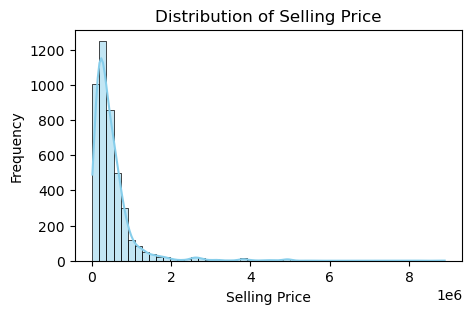

In [57]:
plt.figure(figsize=(5,3))
sns.histplot(df['selling_price'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Selling Price")
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.show()

#### 15.2 Car Age vs Selling Price

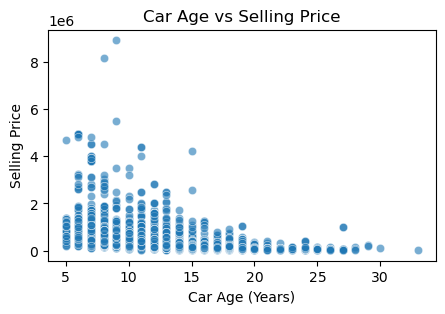

In [59]:
plt.figure(figsize=(5,3))
sns.scatterplot(x='Car_Age', y='selling_price', data=df, alpha=0.6)
plt.title("Car Age vs Selling Price")
plt.xlabel("Car Age (Years)")
plt.ylabel("Selling Price")
plt.show()

#### 15.3 Kilometers Driven vs Selling Price

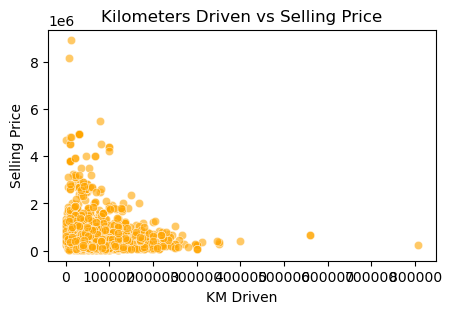

In [61]:
plt.figure(figsize=(5,3))
sns.scatterplot(x='km_driven', y='selling_price', data=df, alpha=0.6, color='orange')
plt.title("Kilometers Driven vs Selling Price")
plt.xlabel("KM Driven")
plt.ylabel("Selling Price")
plt.show()

#### 15.4 Fuel Type vs Average Selling Price

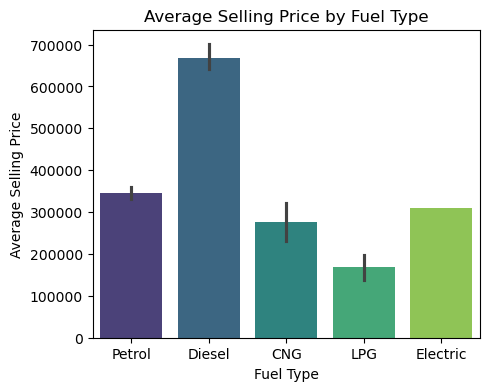

In [63]:
plt.figure(figsize=(5,4))
sns.barplot(x='fuel', y='selling_price', data=df, estimator='mean', palette='viridis')
plt.title("Average Selling Price by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Average Selling Price")
plt.show()

#### 15.5 Transmission Type vs Price

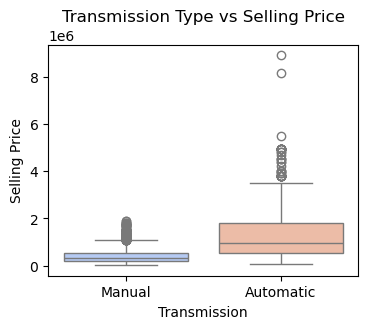

In [65]:
plt.figure(figsize=(4,3))
sns.boxplot(x='transmission', y='selling_price', data=df, palette='coolwarm')
plt.title("Transmission Type vs Selling Price")
plt.xlabel("Transmission")
plt.ylabel("Selling Price")
plt.show()

#### 15.6 Feature Importance Visualization

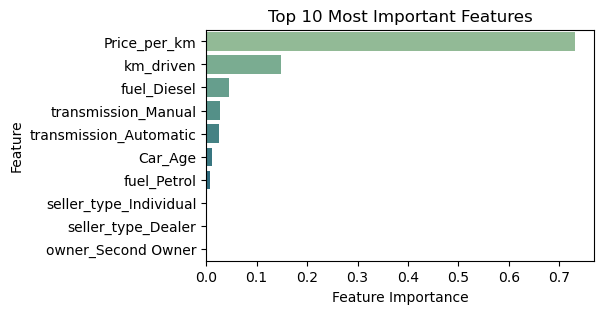

In [67]:
top_features = imp_df.head(10)
plt.figure(figsize=(5,3))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='crest')
plt.title("Top 10 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

---

## 16. Save the Trained Pipeline

Once the model is trained and evaluated, we save the complete pipeline for future use.  
This serialized file includes both preprocessing steps and the trained model,  
so we can directly use it later for predictions without re-running feature engineering or encoding.

Saving the pipeline makes the workflow **reproducible**, **deployable**, and **easy to reuse**.

In [70]:
# Cell 11) Save pipeline
joblib.dump(pipeline, "car_price_pipeline.joblib")
print("Saved as car_price_pipeline.joblib")

Saved as car_price_pipeline.joblib


---

## 16. Results and Insights

After completing data preprocessing, feature engineering, and model training, the **Car Price Prediction Model** produced the following results on the test dataset.


### 16.1 Model Performance Metrics

| Metric | Value | Interpretation |
|---------|--------|----------------|
| RMSE (Root Mean Squared Error) | 221,840.41 | On average, predictions deviate from actual prices by about ₹2.2 lakhs. |
| R² Score | 0.839 | The model explains approximately 83.9% of the variance in selling price, indicating strong predictive power. |

**Interpretation:**  
The model performs well for a real-world dataset with high variability.  
Some deviations are expected due to outliers, such as luxury cars with unusually high resale values.


### 16.2 Key Feature Insights

Based on the feature importance analysis from the Random Forest Regressor:

| Rank | Feature | Importance | Insight |
|------|----------|-------------|----------|
| 1 | Price_per_km | 0.73 | Most influential feature; indicates depreciation trend per kilometer driven. |
| 2 | km_driven | 0.15 | Cars driven more lose value faster. |
| 3 | fuel_Diesel | 0.05 | Diesel cars tend to retain slightly higher resale value than petrol cars. |
| 4 | transmission_Manual | 0.03 | Manual cars dominate resale listings, influencing overall price trends. |
| 5 | Car_Age | 0.01 | Older cars depreciate in value over time, as expected. |

**Observation:**  
`Price_per_km` captures both usage intensity and value retention, making it the strongest predictor.  
This engineered feature significantly improved model performance.


### 16.3 Overall Insights

1. Mileage (`km_driven`) directly influences car resale value—heavy use leads to steeper depreciation.  
2. Car age is a major determinant; newer cars generally have higher prices.  
3. Fuel type affects price—diesel cars tend to retain better value than petrol ones.  
4. Feature engineering, especially `Price_per_km`, played a key role in improving model accuracy.  
5. The Random Forest model effectively captured non-linear relationships and provided interpretable feature importance rankings.


### 16.4 Business Takeaways

- **Sellers:** Can use this model to price used cars competitively based on key parameters like age, mileage, and fuel type.  
- **Buyers:** Can estimate a fair market value before purchasing a car.  
- **Dealers:** Can integrate this model into valuation systems for automated car pricing.


### 16.5 Final Output

The complete trained pipeline was saved as:
This file contains both the **data preprocessing steps** and the **trained Random Forest model**.  
By saving the full pipeline, the entire workflow—from feature transformation to prediction—can be reused directly without repeating preprocessing.  

This makes the solution **reproducible**, **scalable**, and ready for **deployment** in a real-world application or API.


### 16.6 Conclusion

This project successfully demonstrated the development of a **Car Price Prediction Model** using feature engineering, data preprocessing, and ensemble learning techniques.

Key highlights include:
- Effective use of **feature engineering** (`Car_Age`, `Price_per_km`) to enhance predictive power.  
- Implementation of a **robust preprocessing pipeline** ensuring consistency and automation.  
- Training and evaluation of a **Random Forest Regressor** achieving strong performance (**R² = 0.839**, **RMSE ≈ ₹2.2 lakhs**).  
- Clear interpretation of **feature importance**, identifying key drivers of car prices.

The project proves that with the right combination of **data quality, engineered features, and model interpretability**, even a simple model can deliver high accuracy and practical business value.


---

## 17. References

The following references and resources were used during the development of this project for dataset understanding, model implementation, and theoretical guidance:

1. **Dataset Source:**  
   - Car Price Prediction Dataset (Kaggle) — *Used Cars Dataset*  
     [https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho](https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho)

2. **Scikit-learn Documentation:**  
   - Official API Reference for model building and preprocessing tools.  
     [https://scikit-learn.org/stable/documentation.html](https://scikit-learn.org/stable/documentation.html)

3. **Pandas Documentation:**  
   - Used for data manipulation, cleaning, and exploration.  
     [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/)

4. **NumPy Documentation:**  
   - Applied for numerical computations and array operations.  
     [https://numpy.org/doc/](https://numpy.org/doc/)

5. **Matplotlib and Seaborn Documentation:**  
   - Visualization libraries for data exploration and feature analysis.  
     [https://matplotlib.org/stable/index.html](https://matplotlib.org/stable/index.html)  
     [https://seaborn.pydata.org/](https://seaborn.pydata.org/)

6. **Machine Learning Reference Texts:**  
   - Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (3rd Edition)*. O’Reilly Media.  
   - James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). *An Introduction to Statistical Learning (2nd Edition)*. Springer.

7. **Python Official Documentation:**  
   - Reference for general Python syntax, modules, and built-in functions.  
     [https://docs.python.org/3/](https://docs.python.org/3/)


**Citation Note:**  
All external resources were used solely for educational and reference purposes.  
The dataset and methodologies have been applied for learning and demonstration within this project.
